#### Diabetes Prediction-Dataset-Exercise-2-Timothy Gregorian
In this analysis, we examine a large dataset containing 100,000 patient records to understand the key factors that may influence a diabetes diagnosis.
The goal of this project is to build a predictive deep learning model capable of identifying potential diabetes cases based on various health indicators and variables.

In addition, we will explore the relationships between the variables to identify which features have the strongest association with the target variable diabetes.


#### Note
The function kMeans cluster method was used in this project to improve the recall score of the confusion report for positive diagnosis. 

Throughout the project, I followed the lecturer’s GitHub code structure and methodology as closely as possible.
I only used AI and external sources when no examples or references were available in the provided GitHub scripts.

#### Link to Dataset
https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

#### Information about the Dataset
This Diabetes Prediction Dataset contains 100,000 observations and 9 variables related to medical and lifestyle factors that may influence the development of diabetes.
It can be used to train and evaluate classification models for predicting whether a person is likely to have diabetes.

#### Data Description
The dataset consists of the following variables:

1) gender: The biological gender of the individual.

2) age: The age of the individual in years.

3) hypertension: Indicates whether the individual has high blood pressure.

4) heart_disease: Indicates whether the individual has a history of heart disease.

5) smoking_history: The individual’s smoking background.

6) bmi: The Body Mass Index of the individual.

7) HbA1c_level: The hemoglobin A1c level, representing average blood sugar concentration.

8) blood_glucose_level: The current blood glucose level.
9) diabetes: The target variable indicating diabetes diagnosis.

#### Imports / Modules

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

#### Loading the dataset

In [128]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0


Here we check the length of the dataset:

In [129]:
len(df)

100000

#### Handle missing values
According to the table below, we do not have any missing values:

In [130]:
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


We have some duplicates:

In [131]:
int(df.duplicated().sum())

3854

To get a better result with the trained model, we need to remove the duplicates:

In [132]:
df = df.drop_duplicates()

In [133]:
int(df.duplicated().sum())

0

The target variable “diabetes” is imbalanced, with much more non-diabetic (0) and less diabetic (1) cases.
This indicates that the majority of patients in the dataset do not have diabetes, which might affect the model’s ability to correctly identify positive cases.

In [134]:
df['diabetes'].value_counts()

diabetes
0    87664
1     8482
Name: count, dtype: int64

<Axes: >

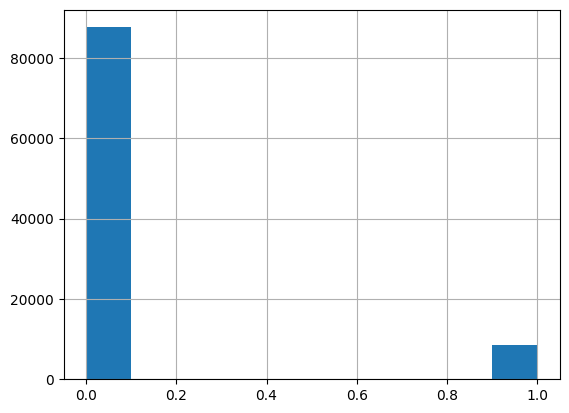

In [135]:
df['diabetes'].hist()

#### OneHotEncoder for the variables "gender" and "smoking_history":

In [136]:
df = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=False)

In [137]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.00,0,1,25.19,6.60,140,0,True,False,False,False,False,False,False,True,False
1,54.00,0,0,27.32,6.60,80,0,True,False,False,True,False,False,False,False,False
2,28.00,0,0,27.32,5.70,158,0,False,True,False,False,False,False,False,True,False
3,36.00,0,0,23.45,5.00,155,0,True,False,False,False,True,False,False,False,False
4,76.00,1,1,20.14,4.80,155,0,False,True,False,False,True,False,False,False,False


#### LabelEncoder

In [138]:
from sklearn.preprocessing import LabelEncoder

variables = [
   'gender_Female',
   'gender_Male',
   'gender_Other',
   'smoking_history_No Info',
   'smoking_history_current',
   'smoking_history_ever',
   'smoking_history_former',
   'smoking_history_never',
   'smoking_history_not current'
]

encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

In [139]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.00,0,1,25.19,6.60,140,0,1,0,0,0,0,0,0,1,0
1,54.00,0,0,27.32,6.60,80,0,1,0,0,1,0,0,0,0,0
2,28.00,0,0,27.32,5.70,158,0,0,1,0,0,0,0,0,1,0
3,36.00,0,0,23.45,5.00,155,0,1,0,0,0,1,0,0,0,0
4,76.00,1,1,20.14,4.80,155,0,0,1,0,0,1,0,0,0,0


#### Artificial Intelligence was used for this code cell
Artificial Intelligence was used for this code cell because I applied the MiniBatchKMeans clustering method to improve the model’s performance, specifically the recall score for predicting positive diabetes cases. I used AI for this step because I could not find any similar example or reference for this method in the lecturer’s provided GitHub code scripts.

In [140]:
from sklearn.cluster import MiniBatchKMeans

X_health = df[["age", "bmi", "HbA1c_level", "blood_glucose_level"]].values

kmeans = MiniBatchKMeans(n_clusters=15, random_state=7)
df["HealthCluster"] = kmeans.fit_predict(X_health)

cluster_mean = df.groupby("HealthCluster")["HbA1c_level"].mean()

df["HealthClusterValue"] = df["HealthCluster"].map(cluster_mean)

df = df.drop(columns=["HealthCluster"])


In [141]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,HealthClusterValue
0,80.00,0,1,25.19,6.60,140,0,1,0,0,0,0,0,0,1,0,5.71
1,54.00,0,0,27.32,6.60,80,0,1,0,0,1,0,0,0,0,0,5.39
2,28.00,0,0,27.32,5.70,158,0,0,1,0,0,0,0,0,1,0,5.41
3,36.00,0,0,23.45,5.00,155,0,1,0,0,0,1,0,0,0,0,5.41
4,76.00,1,1,20.14,4.80,155,0,0,1,0,0,1,0,0,0,0,5.64


#### Correlation

The correlation test shows that the new HealthCluster variable has the strongest positive correlation with the target variable diabetes, followed by blood_glucose_level and HbA1c_level. 

In [142]:
corr_matrix = df.corr()['diabetes']
corr_matrix.sort_values(ascending=False)

diabetes                       1.00
HealthClusterValue             0.62
blood_glucose_level            0.42
HbA1c_level                    0.41
age                            0.26
bmi                            0.21
hypertension                   0.20
heart_disease                  0.17
smoking_history_former         0.10
gender_Male                    0.04
smoking_history_never          0.02
smoking_history_ever           0.02
smoking_history_not current    0.02
smoking_history_current        0.02
gender_Other                  -0.00
gender_Female                 -0.04
smoking_history_No Info       -0.11
Name: diabetes, dtype: float64

#### Variable visual comparison

## NEW COMPARISON ## - age vs diabetes


<Figure size 1000x600 with 0 Axes>

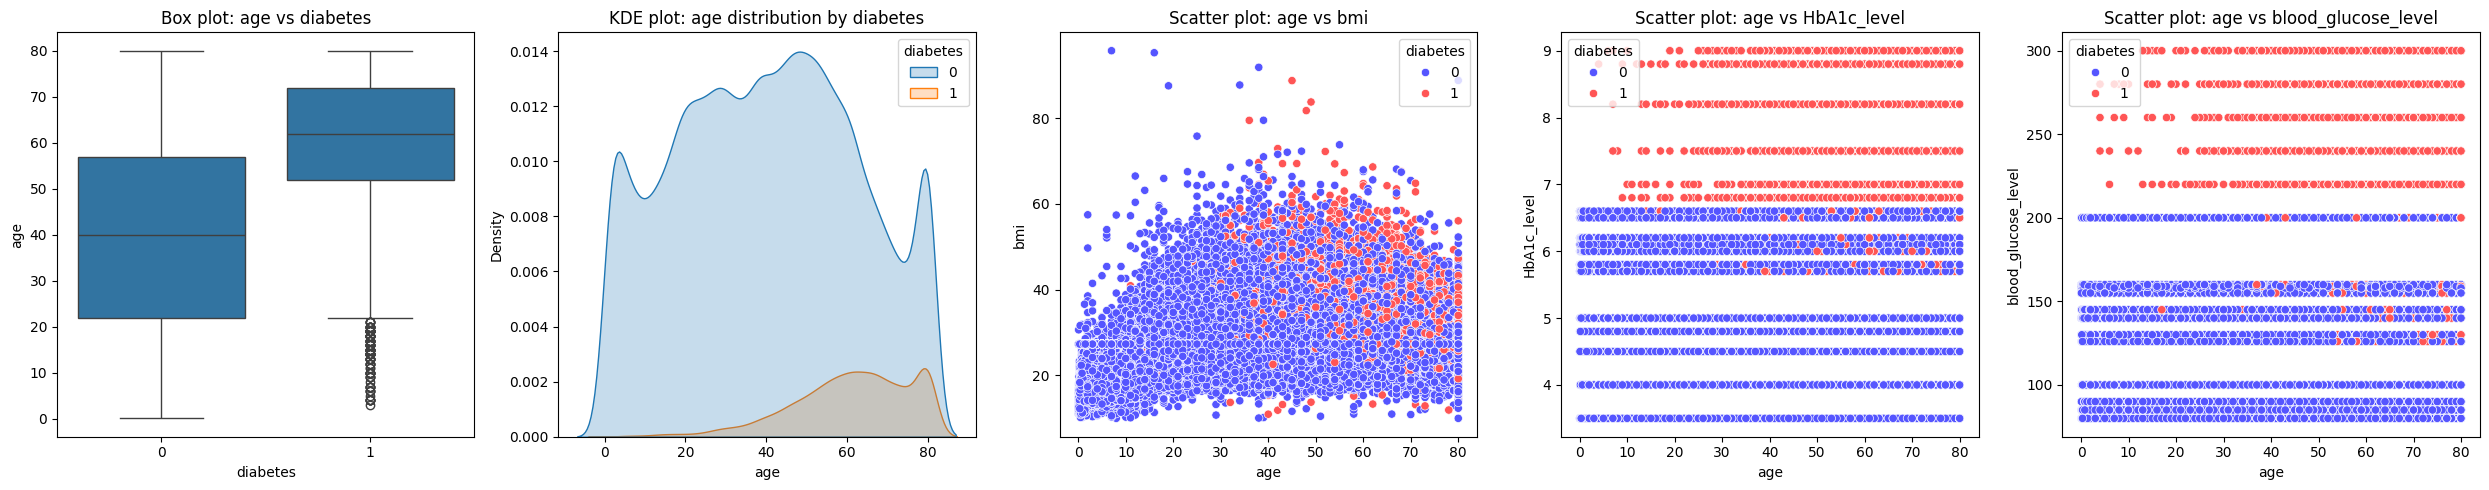

## NEW COMPARISON ## - bmi vs diabetes


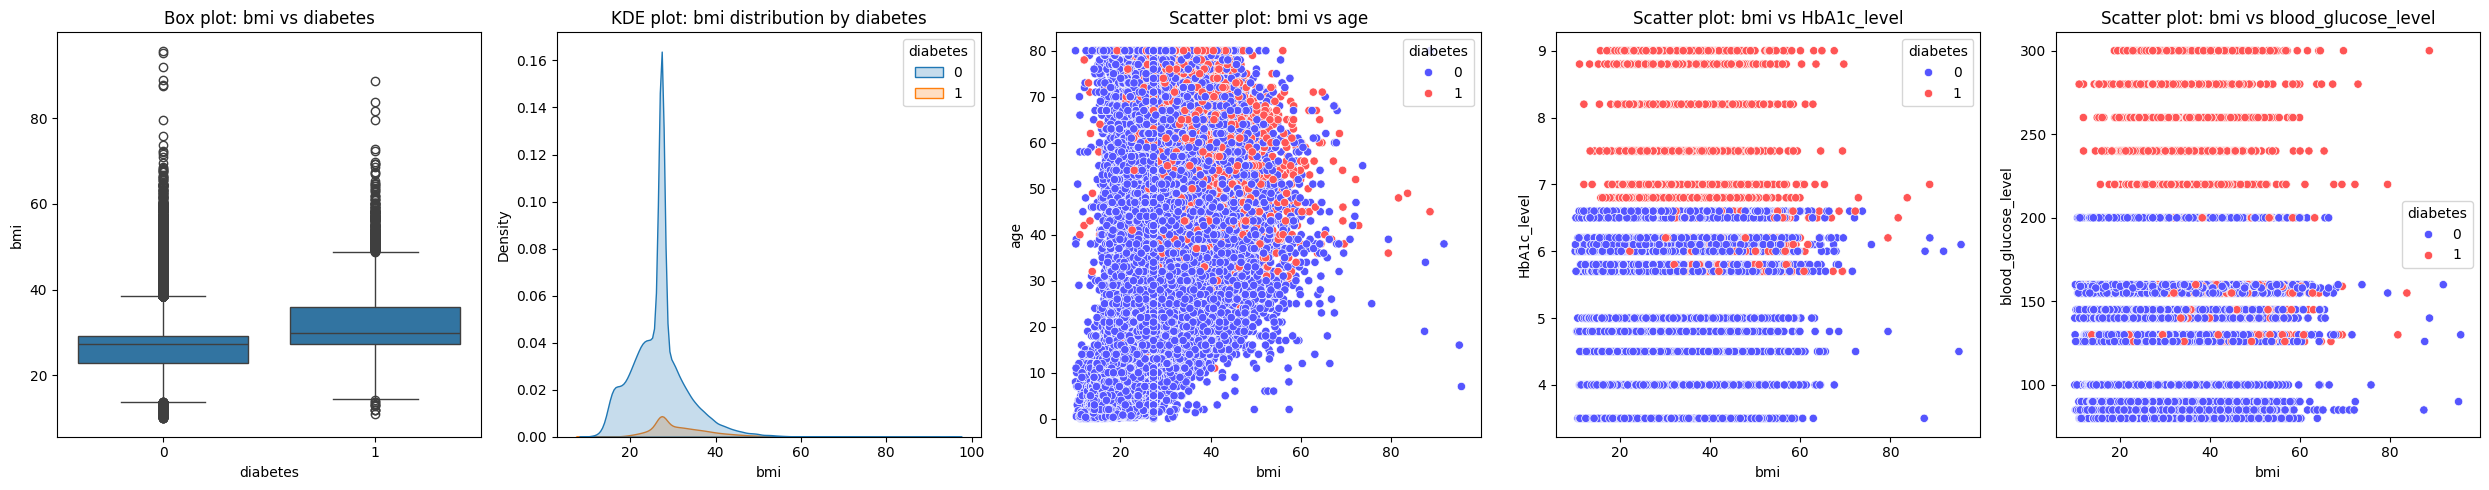

## NEW COMPARISON ## - HbA1c_level vs diabetes


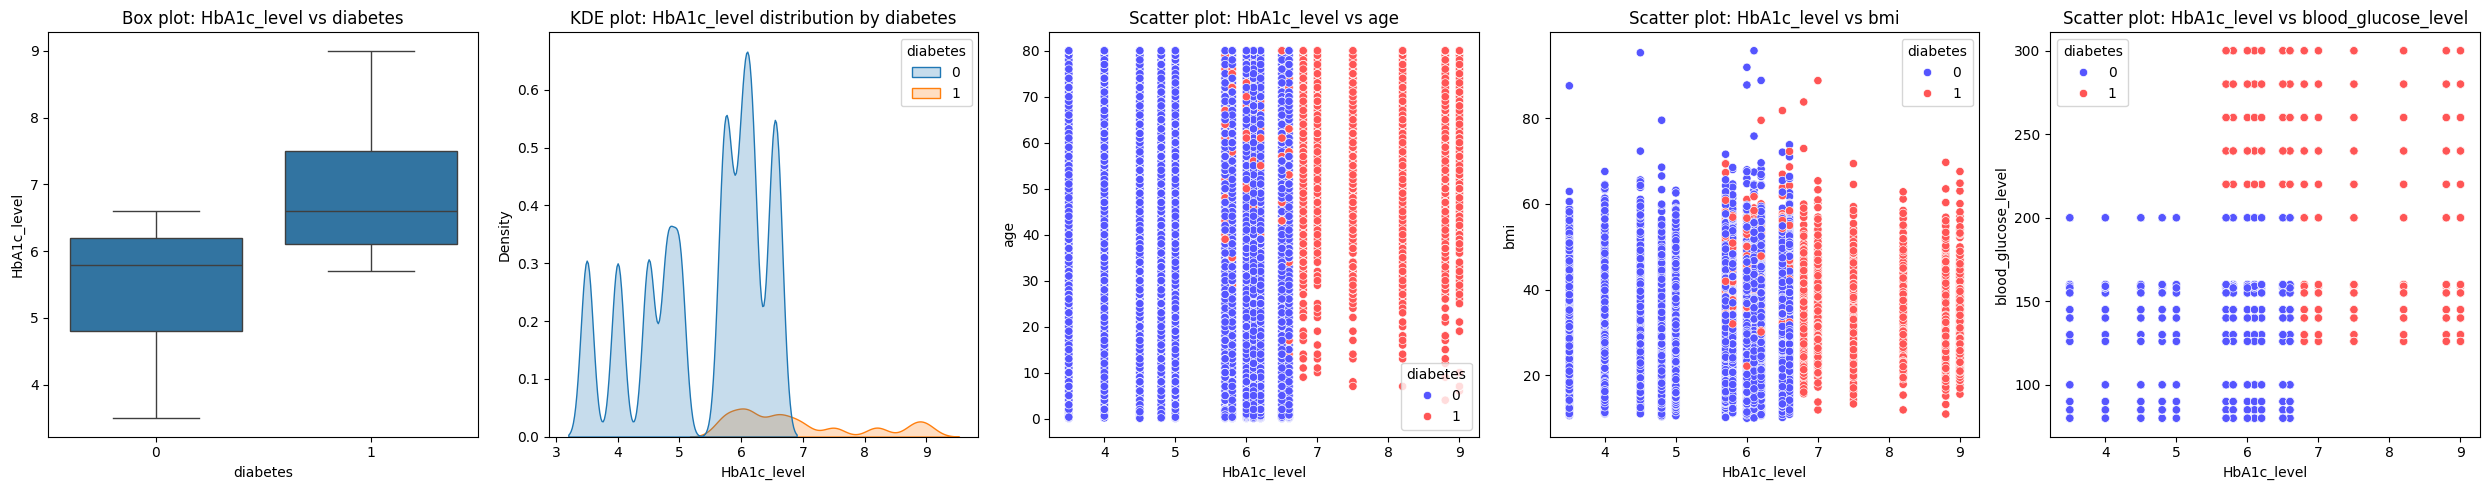

## NEW COMPARISON ## - blood_glucose_level vs diabetes


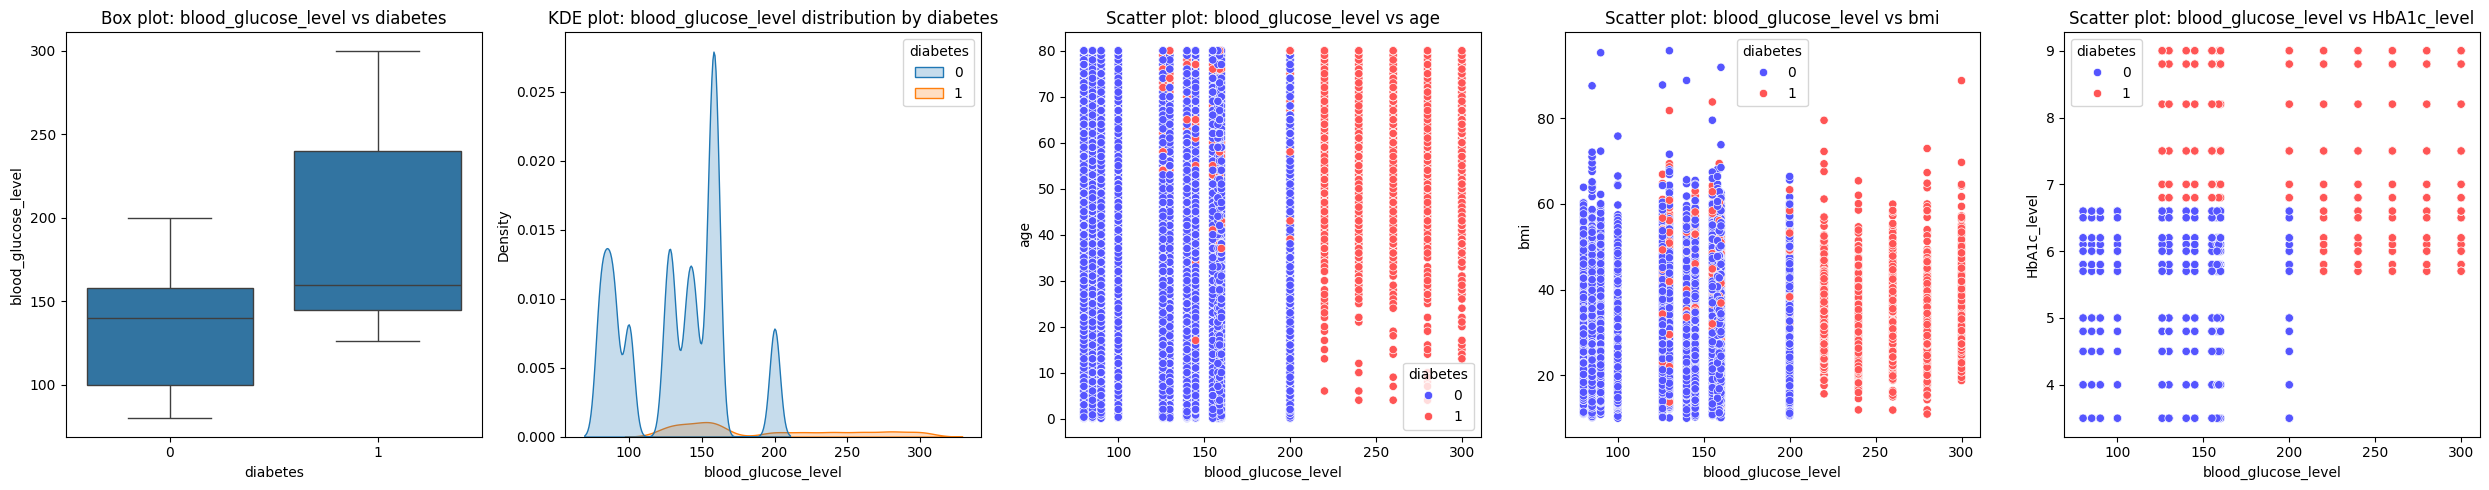

In [143]:
suspected_columns = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
target_variable = 'diabetes'  

plt.figure(figsize=(10, 6))

for feature in suspected_columns:
    print(f"## NEW COMPARISON ## - {feature} vs {target_variable}")
    num_other_features = len([col for col in suspected_columns if col != feature])
    
    fig, axes = plt.subplots(1, 2 + num_other_features, figsize=(5 * (2 + num_other_features), 5))
    
    sns.boxplot(x=target_variable, y=feature, data=df, ax=axes[0])
    axes[0].set_title(f'Box plot: {feature} vs {target_variable}')
    
    sns.kdeplot(x=feature, hue=target_variable, data=df, fill=True, ax=axes[1])
    axes[1].set_title(f'KDE plot: {feature} distribution by {target_variable}')
    
    for i, other_feature in enumerate([col for col in suspected_columns if col != feature]):
        sns.scatterplot(x=feature, palette="seismic", y=other_feature, hue=target_variable, data=df, ax=axes[i + 2])
        axes[i + 2].set_title(f'Scatter plot: {feature} vs {other_feature}')
    
    plt.tight_layout()
    plt.show()


##### 1) Age vs Diabetes
Older individuals tend to have a higher probability of diabetes. The boxplot shows that diabetic patients are generally older than non-diabetic ones.

##### 2) BMI vs Diabetes
Higher BMI values are more common among diabetic individuals. The distribution shows that as BMI increases, the probability of having diabetes also rises slightly.

##### 3) HbA1c-Level vs Diabetes
People with diabetes have clearly higher HbA1c levels compared to non-diabetic individuals. 

##### 4) Blood Glucose Level vs Diabetes
The blood glucose level is significantly higher in diabetic patients, showing a strong relationship with the target variable.


In [144]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,HealthClusterValue
0,80.00,0,1,25.19,6.60,140,0,1,0,0,0,0,0,0,1,0,5.71
1,54.00,0,0,27.32,6.60,80,0,1,0,0,1,0,0,0,0,0,5.39
2,28.00,0,0,27.32,5.70,158,0,0,1,0,0,0,0,0,1,0,5.41
3,36.00,0,0,23.45,5.00,155,0,1,0,0,0,1,0,0,0,0,5.41
4,76.00,1,1,20.14,4.80,155,0,0,1,0,0,1,0,0,0,0,5.64


In this code cell, the target variable diabetes was transformed from numerical values (0 and 1) into categorical labels (“Negative” and “Positive”).

In [145]:
df['diabetes'] = df['diabetes'].replace({
    0: "0: Negative",
    1: "1: Positive"
})

In [146]:
X = df.drop("diabetes", axis=1)

y_temp = df['diabetes']

le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

y = tf.keras.utils.to_categorical(y_enc)

categories = list(le.classes_)
categories

['0: Negative', '1: Positive']

#### Chi²-Test

 According to the results, blood_glucose_level and age show the highest scores, which means that they contribute the most to predicting diabetes. Although we used the kMeans cluster method, the variable does not contribute that much to predicting diabetes.

In [147]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

best_features = chi_2_features.fit(X_cat,y.astype(int))

pd.options.display.float_format = '{:.2f}'.format

df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
5,blood_glucose_level,209621.05
0,age,81580.18
3,bmi,7540.69
4,HbA1c_level,3520.08
1,hypertension,3396.84
2,heart_disease,2687.58
9,smoking_history_No Info,801.71
12,smoking_history_former,791.93
15,HealthClusterValue,175.18
7,gender_Male,80.62


#### Train/Test/Validation-Split (70/30)

In [148]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [149]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,HealthClusterValue
0,80.00,0,1,25.19,6.60,140,0: Negative,1,0,0,0,0,0,0,1,0,5.71
1,54.00,0,0,27.32,6.60,80,0: Negative,1,0,0,1,0,0,0,0,0,5.39
2,28.00,0,0,27.32,5.70,158,0: Negative,0,1,0,0,0,0,0,1,0,5.41
3,36.00,0,0,23.45,5.00,155,0: Negative,1,0,0,0,1,0,0,0,0,5.41
4,76.00,1,1,20.14,4.80,155,0: Negative,0,1,0,0,1,0,0,0,0,5.64


#### Create the neural network

In [152]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

mc = ModelCheckpoint('best_model_classification.keras', monitor='val_accuracy', mode='max', save_best_only=True)

callback_list = [mc]

model3 = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.1)),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

model3.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

d:\5. Semester\Deep Learning\DL-projects\venv312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,794 (14.82 KB)

 Trainable params: 3,762 (14.70 KB)

 Non-trainable params: 32 (128.00 B)

#### Training the neural network

In [153]:
model3.fit(x=X_train, y=y_train, epochs=20, validation_data=(X_val, y_val), callbacks=callback_list)


Epoch 1/20
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9404 - loss: 0.9755 - val_accuracy: 0.9539 - val_loss: 0.1901
Epoch 2/20
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9488 - loss: 0.1994 - val_accuracy: 0.9586 - val_loss: 0.1765
Epoch 3/20
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9499 - loss: 0.1887 - val_accuracy: 0.9605 - val_loss: 0.1713
Epoch 4/20
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9524 - loss: 0.1826 - val_accuracy: 0.9590 - val_loss: 0.1635
Epoch 5/20
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9520 - loss: 0.1800 - val_accuracy: 0.9585 - val_loss: 0.1598
Epoch 6/20
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9539 - loss: 0.1763 - val_accuracy: 0.9633 - val_loss: 0.1521
Epoch 7/20
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9549 - loss: 0.1746 - val_accuracy: 0.9615 - val_loss: 0.1592
Epoch 8/20
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9537 - loss: 0.1754 - 

#### Performance and Confusion Matrix

In the graph below, we see that both curves decrease rapidly at the beginning and then stabilize at a low level, indicating that the model learned efficiently without signs of overfitting.

<Axes: >

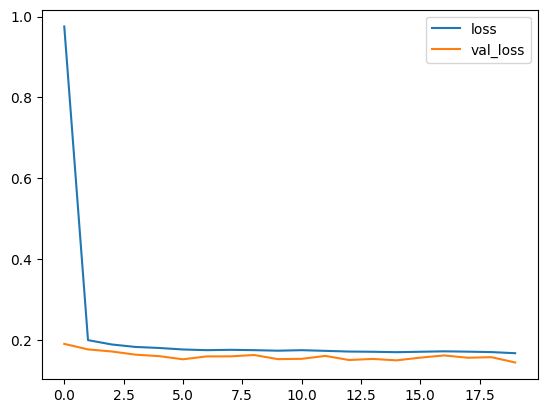

In [154]:
loss_df = pd.DataFrame(model3.history.history)
loss_df[['loss', 'val_loss']].plot()

In the second graph below, we see that the validation accuracy stays slightly above the training accuracy, suggesting that the model generalizes well.

<Axes: >

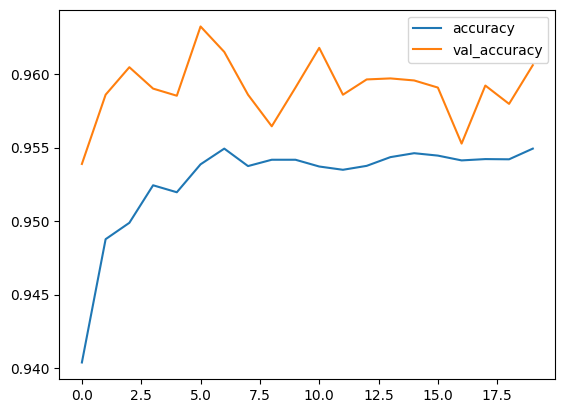

In [155]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [156]:
from keras.models import load_model
model3 = load_model('best_model_classification.keras')

 The close values between training and testing accuracy indicate that the model is well balanced and generalizes effectively without overfitting.

In [157]:
print("Test data evaluation:")
print(model3.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model3.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.14518381655216217, 0.9659547805786133]

Train data evaluation:
[0.14762189984321594, 0.9653353691101074]


In [158]:
test_predictions = model3.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

y_test = np.argmax(y_test, axis=1)

451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


The confusion matrix shows that the model performs very well in distinguishing between negative and positive diabetes cases. What is esepcially great is that there were not any cases of negative predicted diagnosis, turning out as positive.

<Axes: >

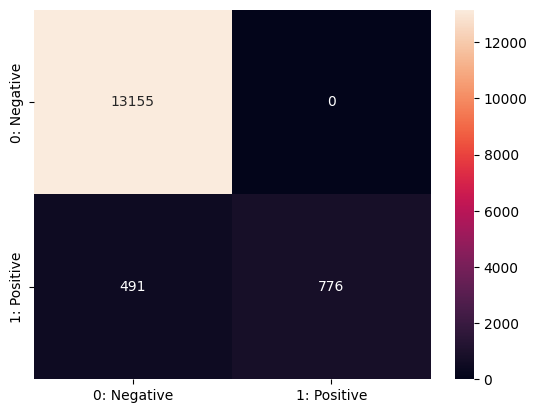

In [159]:
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories)

The classification report shows that the model achieved an overall accuracy of 96.6% with the kMeans clustering method, reaching a higher score than 95.83% from the previous model training. The recall for positive diabetes cases is 0.61, which means that the model correctly identified 61% of patients with diabetes. 

In [160]:
print(classification_report(y_test, test_predictions, target_names=categories))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))


              precision    recall  f1-score   support

 0: Negative       0.96      1.00      0.98     13155
 1: Positive       1.00      0.61      0.76      1267

    accuracy                           0.97     14422
   macro avg       0.98      0.81      0.87     14422
weighted avg       0.97      0.97      0.96     14422


Model overall accuracy: 96.60%


The ROC-AUC score of almost 0.97 shows that the model can distinguish between diabetic and non-diabetic cases and therefore being a reliable model.

In [161]:
roc_auc_score(y, model3.predict(X), multi_class="ovr")

3005/3005 ━━━━━━━━━━━━━━━━━━━━ 2s 823us/step


0.9658166519727915

In [162]:
X.columns

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'gender_Female', 'gender_Male', 'gender_Other',
       'smoking_history_No Info', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current',
       'HealthClusterValue'],
      dtype='object')

In [171]:
df.head(3)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,HealthClusterValue
0,80.00,0,1,25.19,6.60,140,0: Negative,1,0,0,0,0,0,0,1,0,5.71
1,54.00,0,0,27.32,6.60,80,0: Negative,1,0,0,1,0,0,0,0,0,5.39
2,28.00,0,0,27.32,5.70,158,0: Negative,0,1,0,0,0,0,0,1,0,5.41


In [ ]:
tester_row = {
    'age': 80,
    'hypertension': 0,
    'heart_disease': 0,
    'bmi': 27.32,
    'HbA1c_level': 6.0,
    'blood_glucose_level': 80,
    'gender_Female': 0,
    'gender_Male': 1,        
    'gender_Other': 0,
    'smoking_history_No Info': 1,
    'smoking_history_current': 0,
    'smoking_history_ever': 0,
    'smoking_history_former': 0,
    'smoking_history_never': 0,
    'smoking_history_not current': 0,
    'HealthClusterValue': 5.63
}

tester_row = pd.DataFrame([tester_row])
result = model3.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

np.set_printoptions(precision=9, suppress=True)

print(f"Predicted diagnosis: {result_text}")
print()
print("Probabilities by class:")
print(categories)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted diagnosis: 0: Negative

Probabilities by class:
['0: Negative', '1: Positive']
[0.7681647  0.23183529]


#### Conclusion
In this project, I worked on improving a diabetes prediction model. The code trains a neural network using health data and I used  regularization to avoid overfitting. I also used k-Means clustering to help the model find better patterns for predicting positive diabetes cases. After removing duplicate rows, the recall value and overall model performance got a bit better. Also through the use of kMeans cluster method, the model accuracy improved from 95.83% to 96.60%.

I tried my best to follow the lecturer’s GitHub code examples, and only used Artificial Intelligence when no examples were available. This showed me how using clustering and cleaning the data can make the model more accurate and useful in practice. Comparing it with the recent project where we had to do regression, in my opinion using classification was much more easier, due to the simple dataset, I have used for this project.